<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/Metabo2024-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Metabo2024-2**

to do
```
・Finetune pretrained age estimation model
・※pretrained model: MAE=2.88、Metabo2024の最後で検証済み
```

##**Load pretrained weight**

In [30]:
# 必要ライブラリ読み込み
!pip install timm==0.5.4 --q #timmのバージョンが違うとうまくstate dictできないので注意！！！
import random
import timm
import copy
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timm.scheduler import CosineLRScheduler
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os
import glob
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt
%matplotlib inline


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# モデル枠組み読み込み
model = timm.create_model(model_name='swin_base_patch4_window12_384', num_classes=1, pretrained=False)

# GPU使用する場合
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# 学習済みモデル読み込み
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/model_20220903.pth'
#model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.load_state_dict(torch.load(model_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda:0


<ipython-input-30-9a7943c16507>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

###**Load cleaned dataset**

・['AH', 'Blur']を削除したもの

In [ ]:
original_csv_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
original_df = pd.read_csv(original_csv_path)

# Load the provided metabo_disease.csv file again
disease_csv_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/metabo_disease.csv'
disease_df = pd.read_csv(disease_csv_path)

# Filter the disease_df to get only rows where reason is "AH" or "Blur"
#exclude_df = disease_df[disease_df['reason'].isin(['AH', 'Blur', 'ERM', "Hemorrhage", "Coagulation", "VO", "Degeneration", "AMD", "CRA", "Drusen"])]
exclude_df = disease_df[disease_df['reason'].isin(['AH', 'Blur', 'ERM', "Hemorrhage", "Coagulation", "VO", "Degeneration", "AMD", "CRA", "Drusen"])]

# Extract the ids (filenames) from ah_blur_df that match the 'AH' or 'Blur' criteria
ah_blur_ids = exclude_df['id'].tolist()

# Now remove these filenames from comparison_df
cleaned_df = original_df[~original_df['filename'].isin(ah_blur_ids)]
len(cleaned_df)

4618

##**Finetune age estimation model**

1e-7➡2e-6: MSE 13.2399, R2 0.8778

1e-6➡1e-4: MSE


In [ ]:
# Training settings
num_epochs = 200
patience = 10
seed = 42
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"



def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)


# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 1]  # AGEカラムのインデックス

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    #transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    #transforms.RandomGrayscale(p=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = FundusDataset(cleaned_df, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# CosineLRSchedulerの設定
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_t=5,
    warmup_lr_init=1e-7,
    warmup_prefix=True
)

scaler = torch.cuda.amp.GradScaler()


# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            return True
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

# トレーニング関数の修正
def train(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).float()
        inputs = inputs.to(memory_format=torch.channels_last)

        for param in model.parameters():
            param.grad = None

        with torch.amp.autocast(device_type='cuda'):
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(outputs.detach().cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    mse = mean_squared_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)
    return epoch_loss, mse, r2

# 評価関数の修正
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            inputs = inputs.to(memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    mse = mean_squared_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)
    return epoch_loss, mse, r2

# GradScalerの更新
scaler = torch.amp.GradScaler('cuda')

# モデルの出力層の調整（必要に応じて）
# model.fc = nn.Linear(model.fc.in_features, 1)  # 1つの出力（回帰の場合）

# 損失関数の変更
criterion = nn.MSELoss()  # 回帰問題の場合

# トレーニングループの修正
early_stopping = EarlyStopping(patience=patience)
history = {'train_loss': [], 'train_mse': [], 'train_r2': [],
           'val_loss': [], 'val_mse': [], 'val_r2': [], 'lr': []}

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss, train_mse, train_r2 = train(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_mse, val_r2 = evaluate(model, val_loader, criterion, device)

    scheduler.step(epoch + 1)

    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    history['train_loss'].append(train_loss)
    history['train_mse'].append(train_mse)
    history['train_r2'].append(train_r2)
    history['val_loss'].append(val_loss)
    history['val_mse'].append(val_mse)
    history['val_r2'].append(val_r2)

    is_best = early_stopping(val_loss, model)

    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train MSE: {train_mse:.4f}, Train R2: {train_r2:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val MSE: {val_mse:.4f}, Val R2: {val_r2:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print(f"Best model {'updated' if is_best else 'not updated'}")
    print(f"Current learning rate: {current_lr:.6f}")
    print("-" * 40)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# 最終評価の修正
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.to(memory_format=torch.channels_last)
        outputs = model(inputs).squeeze()
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_mse = mean_squared_error(all_labels, all_preds)
final_r2 = r2_score(all_labels, all_preds)
print(f"Final MSE: {final_mse:.4f}")
print(f"Final R2 Score: {final_r2:.4f}")

# 訓練結果のグラフ表示
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(history['train_mse'], label='Train MSE')
plt.plot(history['val_mse'], label='Validation MSE')
plt.title('Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history['train_r2'], label='Train R2')
plt.plot(history['val_r2'], label='Validation R2')
plt.title('R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

# 散布図の追加（サイズを大きくする）
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(all_labels, all_preds, alpha=0.5)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--', lw=2)
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.title('True vs Predicted Values', fontsize=14)

# 残差プロットの追加
residuals = np.array(all_labels) - np.array(all_preds)
plt.subplot(2, 2, 2)
plt.scatter(all_preds, residuals, alpha=0.5)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# MAEの計算
mae = mean_absolute_error(all_labels, all_preds)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

In [ ]:
import torch
import os

# モデルの保存先パスを設定
save_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/age.pth"

# パスが存在することを確認し、必要に応じてディレクトリを作成
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# モデルの状態辞書を保存
torch.save(model.state_dict(), save_path)

print(f"Model saved successfully to {save_path}")

# オプション: モデルの読み込みを確認
# モデルの状態辞書を読み込む
loaded_state_dict = torch.load(save_path)

# 新しいモデルインスタンスに状態辞書を適用する
# (ここでは 'model' が既に定義されていると仮定しています)
model.load_state_dict(loaded_state_dict)

print("Model loaded successfully for verification.")

Model saved successfully to /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/age.pth


<ipython-input-4-bb35c6ae17b9>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state_dict = torch.load(save_path)


Model loaded successfully for verification.


### inference age estimation model

<ipython-input-4-21ef0148c0db>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


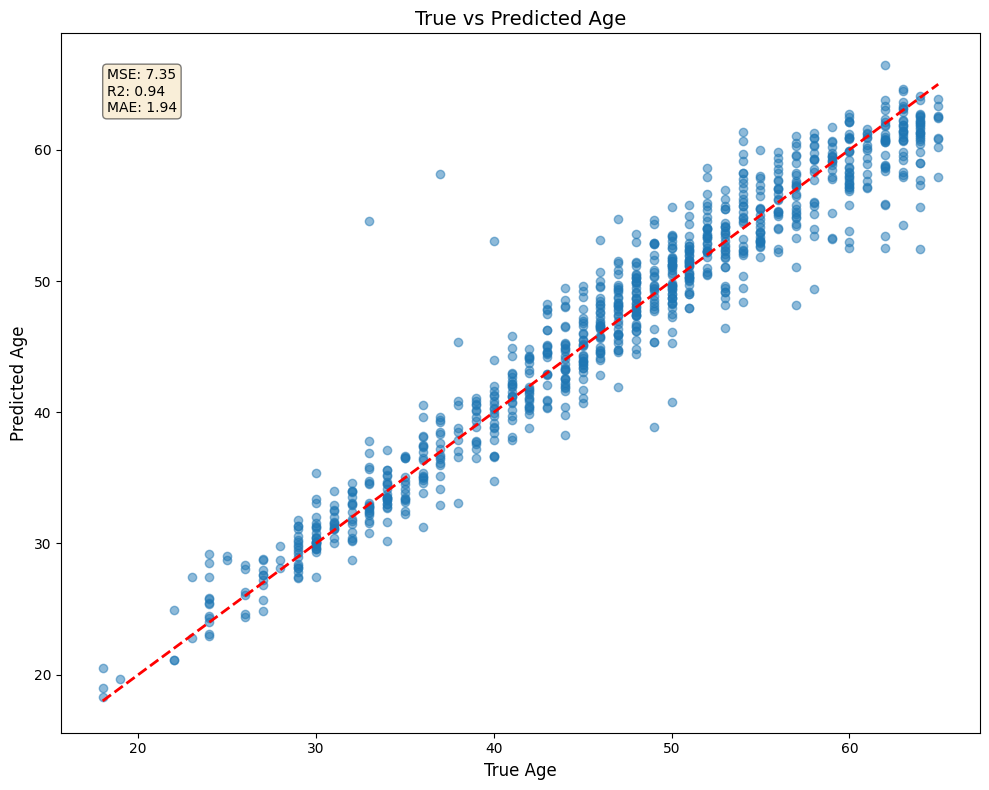

Mean Squared Error (MSE): 7.3465
R-squared (R2) Score: 0.9366
Mean Absolute Error (MAE): 1.9391


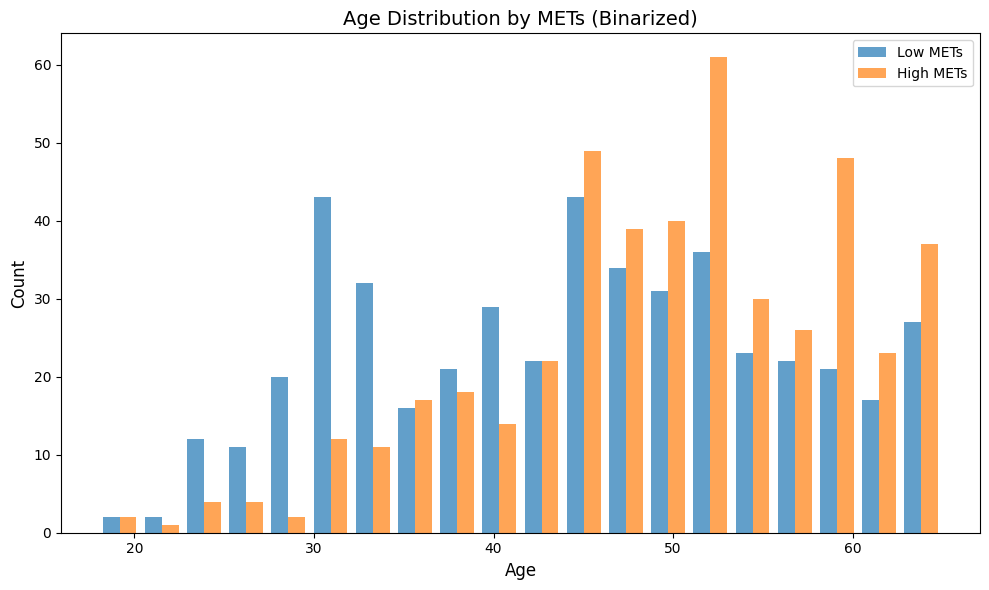

In [ ]:
import torch
import timm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_curve, auc
import os
import random
from sklearn.model_selection import train_test_split

seed = 42
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

class FundusDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        age = self.data.iloc[idx, 1]  # AGEカラムのインデックス
        mets = self.data.iloc[idx, 8]  # METs列のインデックス（2番目と仮定）

        if self.transform:
            image = self.transform(image)

        return image, age, mets

# Split the DataFrame first
train_df, val_df = train_test_split(cleaned_df, test_size=0.2, random_state=seed)

# Define transforms for validation
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create FundusDataset only for validation data
val_dataset = FundusDataset(val_df, img_dir, transform=transform_val)

# Create DataLoader
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# Load the saved model
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/age.pth'
model = timm.create_model('swin_base_patch4_window12_384', num_classes=1, pretrained=False)
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Perform inference
all_preds = []
all_ages = []
all_mets = []

with torch.no_grad():
    for inputs, ages, mets in val_loader:
        inputs, ages = inputs.to(device), ages.to(device)
        outputs = model(inputs).squeeze()
        all_preds.extend(outputs.cpu().numpy())
        all_ages.extend(ages.cpu().numpy())
        all_mets.extend(mets.numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_ages = np.array(all_ages)
all_mets = np.array(all_mets)

# Binarize METs values
mets_threshold = np.median(all_mets)  # または適切な閾値を設定
all_mets_binary = (all_mets > mets_threshold).astype(int)

# Calculate metrics
mse = mean_squared_error(all_ages, all_preds)
r2 = r2_score(all_ages, all_preds)
mae = mean_absolute_error(all_ages, all_preds)

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(all_ages, all_preds, alpha=0.5)
plt.plot([min(all_ages), max(all_ages)], [min(all_ages), max(all_ages)], 'r--', lw=2)
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('True vs Predicted Age', fontsize=14)

# Add text box with metrics
textstr = f'MSE: {mse:.2f}\nR2: {r2:.2f}\nMAE: {mae:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Visualize age distribution by METs
plt.figure(figsize=(10, 6))
plt.hist([all_ages[all_mets_binary == 0], all_ages[all_mets_binary == 1]],
         label=['Low METs', 'High METs'], bins=20, alpha=0.7)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Age Distribution by METs (Binarized)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()



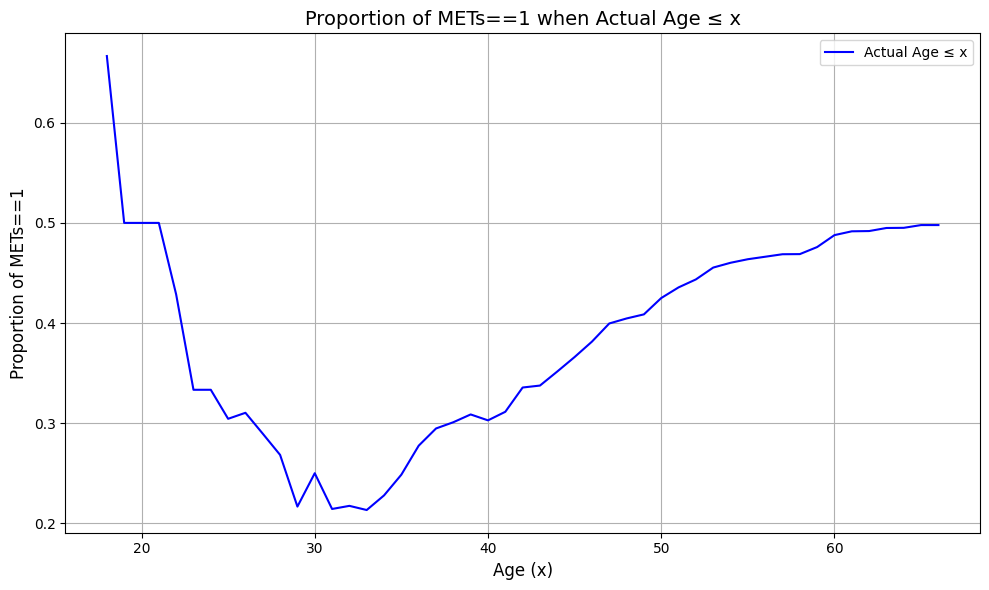

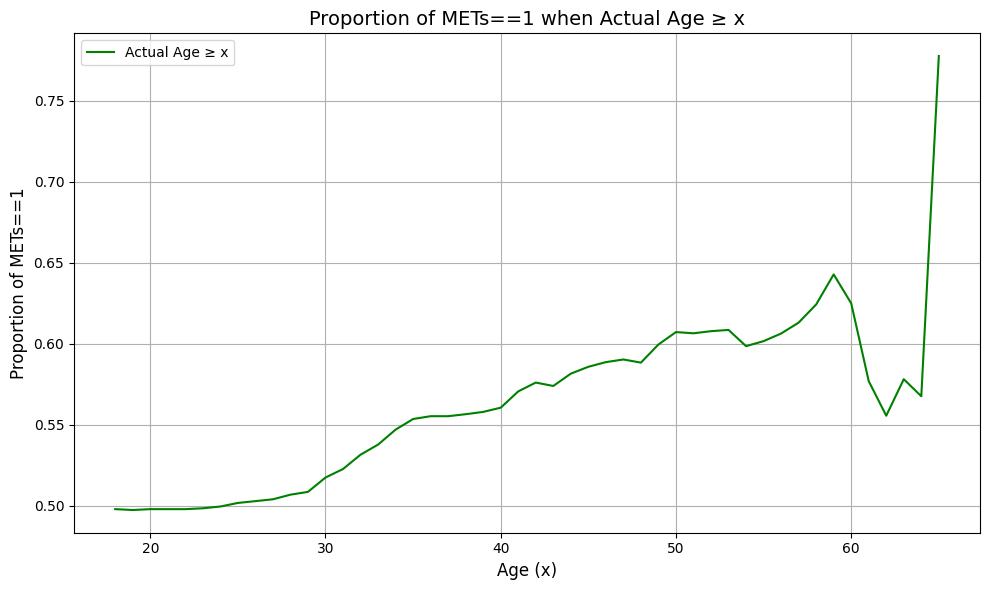

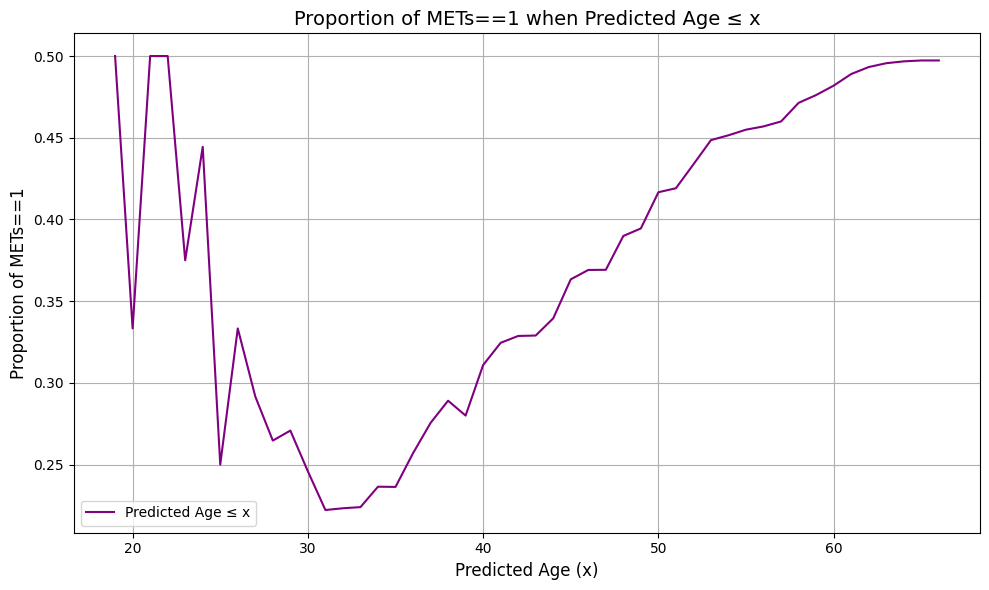

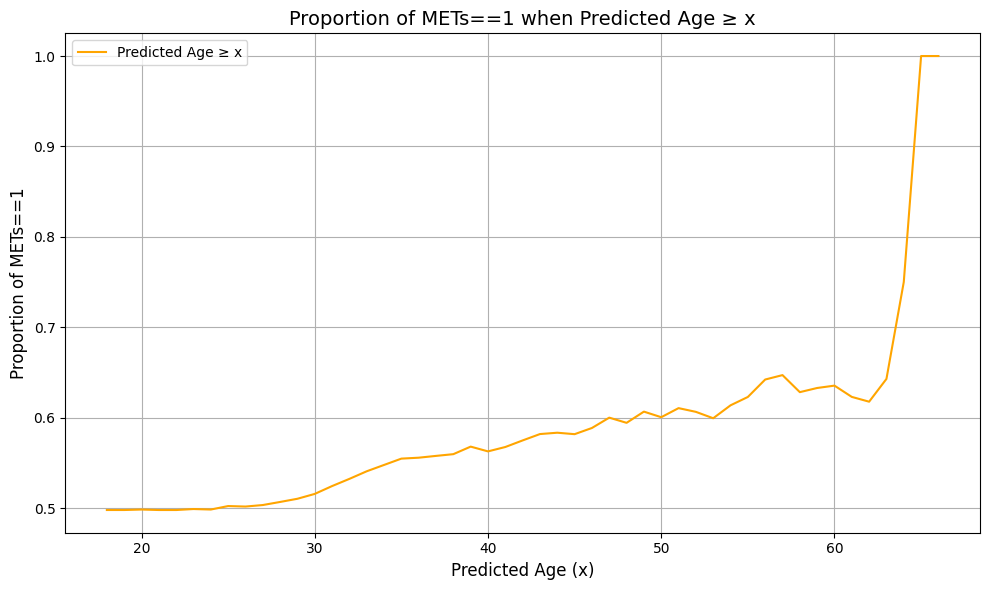

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compute_proportion(x_values, ages, preds, mets_binary, condition='actual', direction='leq'):
    """
    Computes the proportion of METs==1 based on the condition.

    Parameters:
    - x_values: Array of threshold values.
    - ages: Array of true ages.
    - preds: Array of predicted ages.
    - mets_binary: Array of METs binary values.
    - condition: 'actual' or 'predicted' to specify which age to use.
    - direction: 'leq' for <= x, 'geq' for >= x.

    Returns:
    - proportions: List of proportions corresponding to each x.
    """
    proportions = []
    for x in x_values:
        if condition == 'actual':
            if direction == 'leq':
                mask = ages <= x
            else:
                mask = ages >= x
        elif condition == 'predicted':
            if direction == 'leq':
                mask = preds <= x
            else:
                mask = preds >= x
        else:
            raise ValueError("Condition must be 'actual' or 'predicted'.")

        if np.sum(mask) == 0:
            proportion = np.nan  # Avoid division by zero
        else:
            proportion = mets_binary[mask].mean()
        proportions.append(proportion)
    return proportions

# Define x range based on actual and predicted ages
min_age = int(min(all_ages.min(), all_preds.min()))
max_age = int(max(all_ages.max(), all_preds.max()))
x_values = np.arange(min_age, max_age + 1, 1)  # Step of 1 year

# ❶ Actual Age ≤ x
proportions_actual_leq = compute_proportion(
    x_values, all_ages, all_preds, all_mets_binary,
    condition='actual', direction='leq'
)

plt.figure(figsize=(5, 3))
plt.plot(x_values, proportions_actual_leq, label='Actual Age ≤ x', color='blue')
plt.xlabel('Age (x)', fontsize=12)
plt.ylabel('Proportion of METs==1', fontsize=12)
plt.title('Proportion of METs==1 when Actual Age ≤ x', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ❷ Actual Age ≥ x
proportions_actual_geq = compute_proportion(
    x_values, all_ages, all_preds, all_mets_binary,
    condition='actual', direction='geq'
)

plt.figure(figsize=(5, 3))
plt.plot(x_values, proportions_actual_geq, label='Actual Age ≥ x', color='green')
plt.xlabel('Age (x)', fontsize=12)
plt.ylabel('Proportion of METs==1', fontsize=12)
plt.title('Proportion of METs==1 when Actual Age ≥ x', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ❸ Predicted Age ≤ x
proportions_pred_leq = compute_proportion(
    x_values, all_ages, all_preds, all_mets_binary,
    condition='predicted', direction='leq'
)

plt.figure(figsize=(5, 3))
plt.plot(x_values, proportions_pred_leq, label='Predicted Age ≤ x', color='purple')
plt.xlabel('Predicted Age (x)', fontsize=12)
plt.ylabel('Proportion of METs==1', fontsize=12)
plt.title('Proportion of METs==1 when Predicted Age ≤ x', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ❹ Predicted Age ≥ x
proportions_pred_geq = compute_proportion(
    x_values, all_ages, all_preds, all_mets_binary,
    condition='predicted', direction='geq'
)

plt.figure(figsize=(5, 3))
plt.plot(x_values, proportions_pred_geq, label='Predicted Age ≥ x', color='orange')
plt.xlabel('Predicted Age (x)', fontsize=12)
plt.ylabel('Proportion of METs==1', fontsize=12)
plt.title('Proportion of METs==1 when Predicted Age ≥ x', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 学習がうまくいかないことに対する対応版

##**Finetune other classification model**

```
分ける基準
Age: <45: 1901, >=58: 929 --> age estimation modelが完成済
AC: <85: 1555, >=95: 1410
SBP: <125: 1429, >=140: 1374
DBP: <80: 2055, >=85: 2111
HDLC: <45: 1349, >60: 1496
TG: <100: 1608, >=200: 1414
#BS: <75: 204, >=130: 398 --> 眼底で分別
```

In [19]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset from your specified path
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv'
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Create new columns to classify the data based on the provided thresholds
data['AC_class'] = data['AC'].apply(lambda x: 'low' if x < 85 else 'high' if x >= 95 else 'mid')
data['SBP_class'] = data['SBP'].apply(lambda x: 'low' if x < 125 else 'high' if x >= 140 else 'mid')
data['DBP_class'] = data['DBP'].apply(lambda x: 'low' if x < 80 else 'high' if x >= 85 else 'mid')
data['HDLC_class'] = data['HDLC'].apply(lambda x: 'low' if x < 45 else 'high' if x > 60 else 'mid')
data['TG_class'] = data['TG'].apply(lambda x: 'low' if x < 100 else 'high' if x >= 200 else 'mid')


data[['filename', 'AC_class', 'SBP_class', 'DBP_class', 'HDLC_class', 'TG_class']].head()


,filename,AC_class,SBP_class,DBP_class,HDLC_class,TG_class
0,img75151275_00_1R.jpg,high,high,high,mid,mid
1,img96940480_00_1R.jpg,low,high,high,mid,mid
2,img15900654_00_1R.jpg,high,mid,high,mid,mid
3,img74960801_00_1R.jpg,mid,mid,high,high,mid
4,img37629509_00_1R.jpg,high,mid,low,mid,low


In [21]:
!pip install timm==0.5.4 --q #timmのバージョンが違うとうまくstate dictできないので注意！！！

In [ ]:
import os
import random
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from timm.scheduler import CosineLRScheduler
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import torch.backends.cudnn as cudnn
import timm

# Ensure deterministic behavior for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    cudnn.deterministic = True

# Training settings
num_epochs = 200
patience = 5
seed = 42
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"

seed_everything(seed)

# Filter the dataset to include only 'high' and 'low' in 'AC_class'
filtered_df = data[data['AC_class'].isin(['high', 'low'])].reset_index(drop=True)

# Map 'high' to 1 and 'low' to 0
label_map = {'low': 0, 'high': 1}
filtered_df['AC_class'] = filtered_df['AC_class'].map(label_map)

# Dataset class definition
class FundusDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.loc[idx, 'filename'])
        image = Image.open(img_name).convert('RGB')
        label = self.data.loc[idx, 'AC_class']
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations and augmentations
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and dataloaders
full_dataset = FundusDataset(filtered_df, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed)
)

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# Load model
model = timm.create_model(model_name='swin_base_patch4_window12_384', num_classes=1, pretrained=False)

# GPU使用する場合
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# 学習済みモデル読み込み
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/model_20220903.pth'
model.load_state_dict(torch.load(model_path))

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# CosineLRScheduler settings
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-7,
    warmup_t=5,
    warmup_lr_init=1e-7,
    warmup_prefix=True,
)

scaler = torch.cuda.amp.GradScaler()

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

# Training function
def train(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).float()
        inputs = inputs.to(memory_format=torch.channels_last)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        all_preds.extend((torch.sigmoid(outputs) >= 0.5).float().cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = accuracy_score(all_targets, all_preds)
    return epoch_loss, epoch_accuracy

# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            inputs = inputs.to(memory_format=torch.channels_last)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            all_preds.extend((torch.sigmoid(outputs) >= 0.5).float().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = accuracy_score(all_targets, all_preds)
    return epoch_loss, epoch_accuracy

# Training loop
early_stopping = EarlyStopping(patience=patience)
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step(epoch + 1)

    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if early_stopping(val_loss, model):
        print("Early stopping triggered")
        break

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print(f"Current learning rate: {current_lr:.6f}")
    print("-" * 40)

# Final evaluation and ROC curve plotting
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        inputs = inputs.to(memory_format=torch.channels_last)
        outputs = model(inputs)

        probs = torch.sigmoid(outputs).cpu().numpy()
        if probs.ndim == 0: # 0次元配列なら item() を使う
            all_probs.append(probs.item())
        elif probs.ndim == 1 and len(probs) == 1:  # 要素が一つの1次元配列なら item()を使う
            all_probs.append(probs.item())
        else: # それ以外（多次元配列）ならtolist()を使う
             all_probs.extend(probs.tolist())

        all_labels.extend(labels.cpu().numpy().tolist())

# Calculate final metrics
final_accuracy = accuracy_score(all_labels, (np.array(all_probs) >= 0.5).astype(int))
final_auc = roc_auc_score(all_labels, all_probs)
print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final ROC AUC: {final_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot training history and ROC curve
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


# Threshold analysis and visualization:
thresholds = np.linspace(0, 1, 101)  # 101 points between 0 and 1
tpr_values = []
tnr_values = []

for threshold in thresholds:
    predictions = (np.array(all_probs) >= threshold).astype(int)
    cm = confusion_matrix(all_labels, predictions)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0 # Handle potential division by zero
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0 # Handle potential division by zero
    tpr_values.append(tpr)
    tnr_values.append(tnr)

plt.figure(figsize=(4, 3))
plt.plot(thresholds, tpr_values, label='Sensitivity (TPR)') # True positive rate
plt.plot(thresholds, tnr_values, label='Specificity (TNR)') # True negative rate
plt.xlabel('Threshold')
plt.ylabel('Probability')
plt.title('Sensitivity and Specificity vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

cuda:0


<ipython-input-31-b096b583bc92>:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
<ipython-input-31-b096b583bc92>:115: FutureWa

Epoch 1/200
Train Loss: 22.7284, Train Accuracy: 0.4722
Val Loss: 21.5192, Val Accuracy: 0.4890
Epoch duration: 159.68 seconds
Current learning rate: 0.000002
----------------------------------------


<ipython-input-31-b096b583bc92>:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/200
Train Loss: 18.9692, Train Accuracy: 0.4722
Val Loss: 13.9976, Val Accuracy: 0.4890
Epoch duration: 159.84 seconds
Current learning rate: 0.000004
----------------------------------------


<ipython-input-31-b096b583bc92>:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/200
Train Loss: 3.6736, Train Accuracy: 0.5325
Val Loss: 0.7886, Val Accuracy: 0.5936
Epoch duration: 161.01 seconds
Current learning rate: 0.000006
----------------------------------------


<ipython-input-31-b096b583bc92>:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/200
Train Loss: 0.7630, Train Accuracy: 0.5755
Val Loss: 0.6969, Val Accuracy: 0.5616
Epoch duration: 161.35 seconds
Current learning rate: 0.000008
----------------------------------------


<ipython-input-31-b096b583bc92>:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/200
Train Loss: 0.6972, Train Accuracy: 0.6012
Val Loss: 0.6736, Val Accuracy: 0.6071
Epoch duration: 161.56 seconds
Current learning rate: 0.000010
----------------------------------------


<ipython-input-31-b096b583bc92>:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6/200
Train Loss: 0.6723, Train Accuracy: 0.6151
Val Loss: 0.6759, Val Accuracy: 0.5852
Epoch duration: 161.37 seconds
Current learning rate: 0.000010
----------------------------------------


<ipython-input-31-b096b583bc92>:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7/200
Train Loss: 0.6586, Train Accuracy: 0.6395
Val Loss: 0.7976, Val Accuracy: 0.5346
Epoch duration: 161.43 seconds
Current learning rate: 0.000010
----------------------------------------


<ipython-input-31-b096b583bc92>:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


KeyboardInterrupt: 

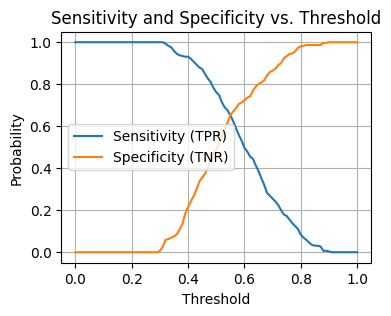

Training model for AC
Epoch 1/200
Train Loss: 0.7013, Train Accuracy: 0.5030
Val Loss: 0.6925, Val Accuracy: 0.5177
Epoch duration: 168.11 seconds
Current learning rate: 0.000020
Best model updated
----------------------------------------
Epoch 2/200
Train Loss: 0.7367, Train Accuracy: 0.4937
Val Loss: 0.7036, Val Accuracy: 0.5093
Epoch duration: 167.56 seconds
Current learning rate: 0.000040
Best model not updated
----------------------------------------
Epoch 3/200
Train Loss: 0.7124, Train Accuracy: 0.4996
Val Loss: 0.6864, Val Accuracy: 0.5497
Epoch duration: 167.46 seconds
Current learning rate: 0.000060
Best model updated
----------------------------------------
Epoch 4/200
Train Loss: 0.7025, Train Accuracy: 0.5211
Val Loss: 0.6830, Val Accuracy: 0.5683
Epoch duration: 167.96 seconds
Current learning rate: 0.000080
Best model updated
----------------------------------------
Epoch 5/200
Train Loss: 0.7081, Train Accuracy: 0.5059
Val Loss: 0.6950, Val Accuracy: 0.5093
Epoch durati

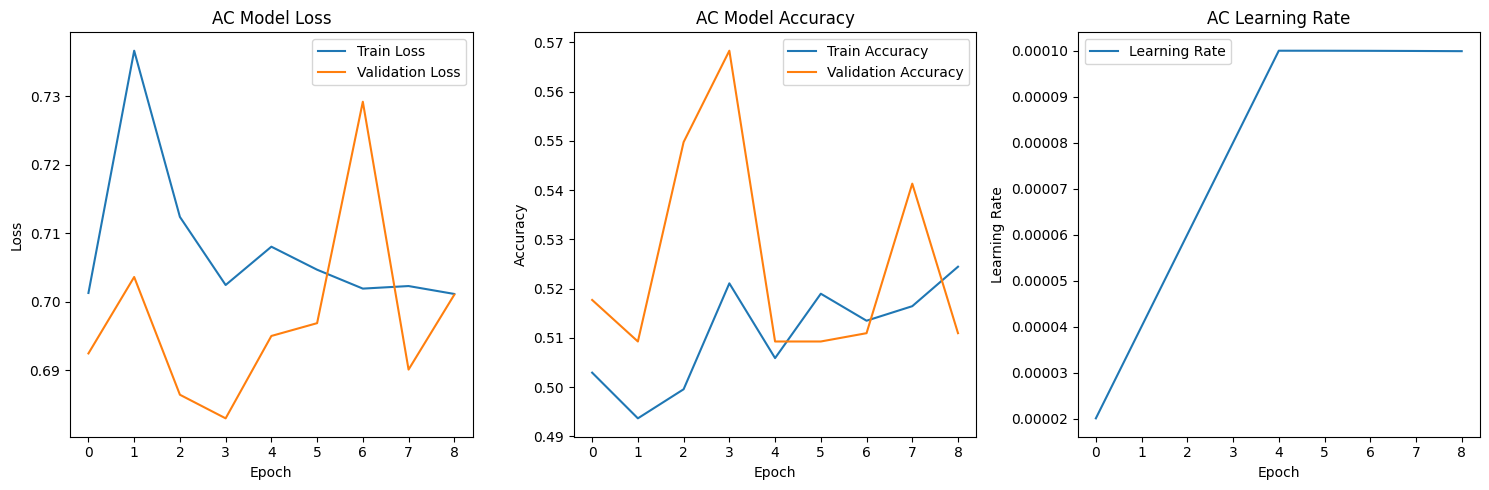

Training model for SBP
Epoch 1/200
Train Loss: 0.7037, Train Accuracy: 0.5045
Val Loss: 0.6905, Val Accuracy: 0.5223
Epoch duration: 585.51 seconds
Current learning rate: 0.000020
Best model updated
----------------------------------------
Epoch 2/200
Train Loss: 0.7333, Train Accuracy: 0.5223
Val Loss: 0.6916, Val Accuracy: 0.4955
Epoch duration: 159.34 seconds
Current learning rate: 0.000040
Best model not updated
----------------------------------------
Epoch 3/200
Train Loss: 0.7148, Train Accuracy: 0.5129
Val Loss: 0.7023, Val Accuracy: 0.4813
Epoch duration: 158.99 seconds
Current learning rate: 0.000060
Best model not updated
----------------------------------------
Epoch 4/200
Train Loss: 0.7107, Train Accuracy: 0.4871
Val Loss: 0.6991, Val Accuracy: 0.5116
Epoch duration: 158.86 seconds
Current learning rate: 0.000080
Best model not updated
----------------------------------------
Epoch 5/200
Train Loss: 0.7017, Train Accuracy: 0.5397
Val Loss: 0.6917, Val Accuracy: 0.5330
Epo

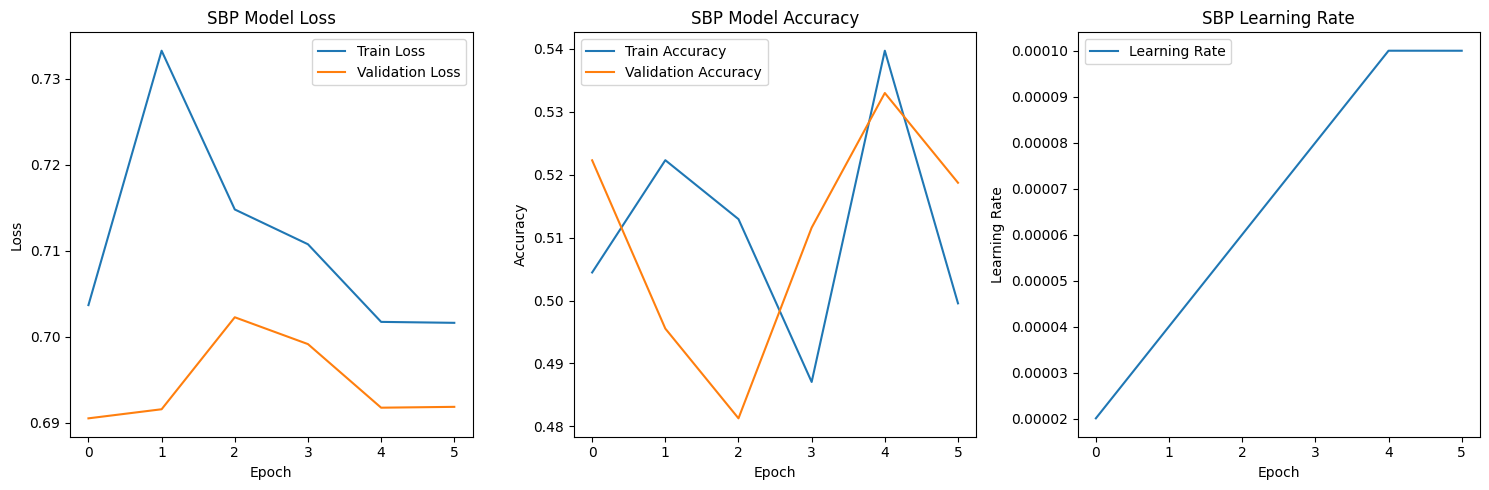

Training model for DBP
Epoch 1/200
Train Loss: 0.7044, Train Accuracy: 0.4844
Val Loss: 0.6964, Val Accuracy: 0.4844
Epoch duration: 543.75 seconds
Current learning rate: 0.000020
Best model updated
----------------------------------------
Epoch 2/200
Train Loss: 0.7159, Train Accuracy: 0.5243
Val Loss: 0.8282, Val Accuracy: 0.5024
Epoch duration: 236.62 seconds
Current learning rate: 0.000040
Best model not updated
----------------------------------------
Epoch 3/200
Train Loss: 0.6984, Train Accuracy: 0.5471
Val Loss: 0.6759, Val Accuracy: 0.5767
Epoch duration: 236.06 seconds
Current learning rate: 0.000060
Best model updated
----------------------------------------
Epoch 4/200
Train Loss: 0.6972, Train Accuracy: 0.5447
Val Loss: 0.6849, Val Accuracy: 0.5983
Epoch duration: 235.89 seconds
Current learning rate: 0.000080
Best model not updated
----------------------------------------
Epoch 5/200
Train Loss: 0.6983, Train Accuracy: 0.5147
Val Loss: 0.7098, Val Accuracy: 0.5060
Epoch d

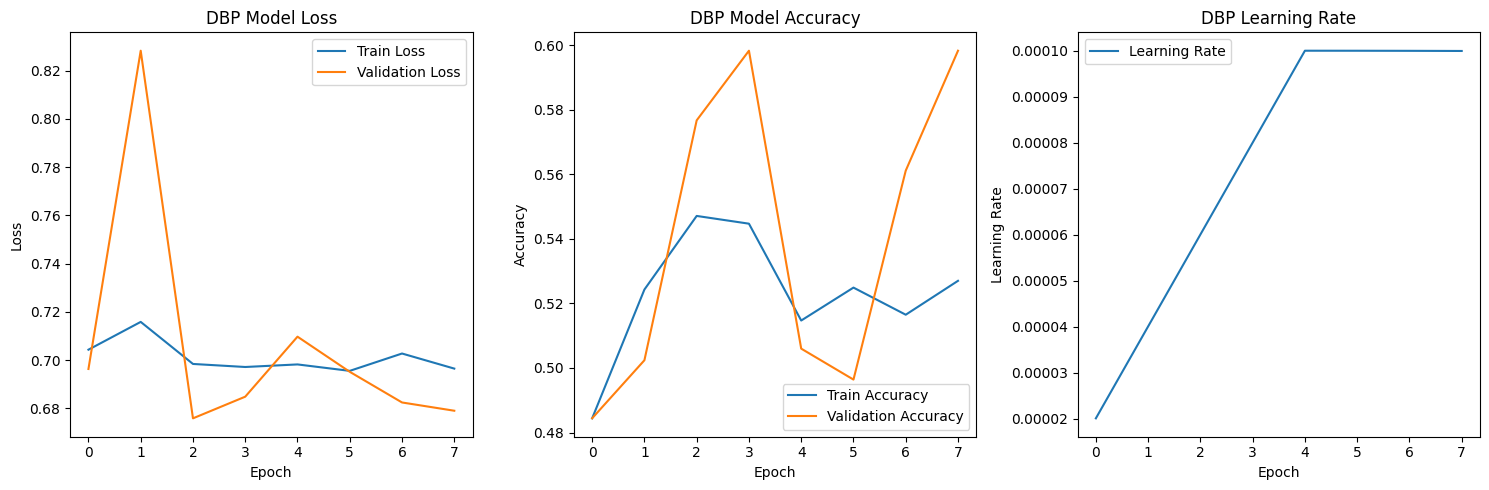

Training model for HDLC
Epoch 1/200
Train Loss: 0.6991, Train Accuracy: 0.4973
Val Loss: 0.6936, Val Accuracy: 0.5255
Epoch duration: 208.52 seconds
Current learning rate: 0.000020
Best model updated
----------------------------------------
Epoch 2/200
Train Loss: 0.7426, Train Accuracy: 0.4909
Val Loss: 0.7062, Val Accuracy: 0.5255
Epoch duration: 155.28 seconds
Current learning rate: 0.000040
Best model not updated
----------------------------------------
Epoch 3/200
Train Loss: 0.7147, Train Accuracy: 0.5127
Val Loss: 0.6924, Val Accuracy: 0.5236
Epoch duration: 155.47 seconds
Current learning rate: 0.000060
Best model updated
----------------------------------------
Epoch 4/200
Train Loss: 0.7117, Train Accuracy: 0.5032
Val Loss: 0.6988, Val Accuracy: 0.5255
Epoch duration: 155.49 seconds
Current learning rate: 0.000080
Best model not updated
----------------------------------------
Epoch 5/200
Train Loss: 0.7098, Train Accuracy: 0.5132
Val Loss: 0.6935, Val Accuracy: 0.5182
Epoch 

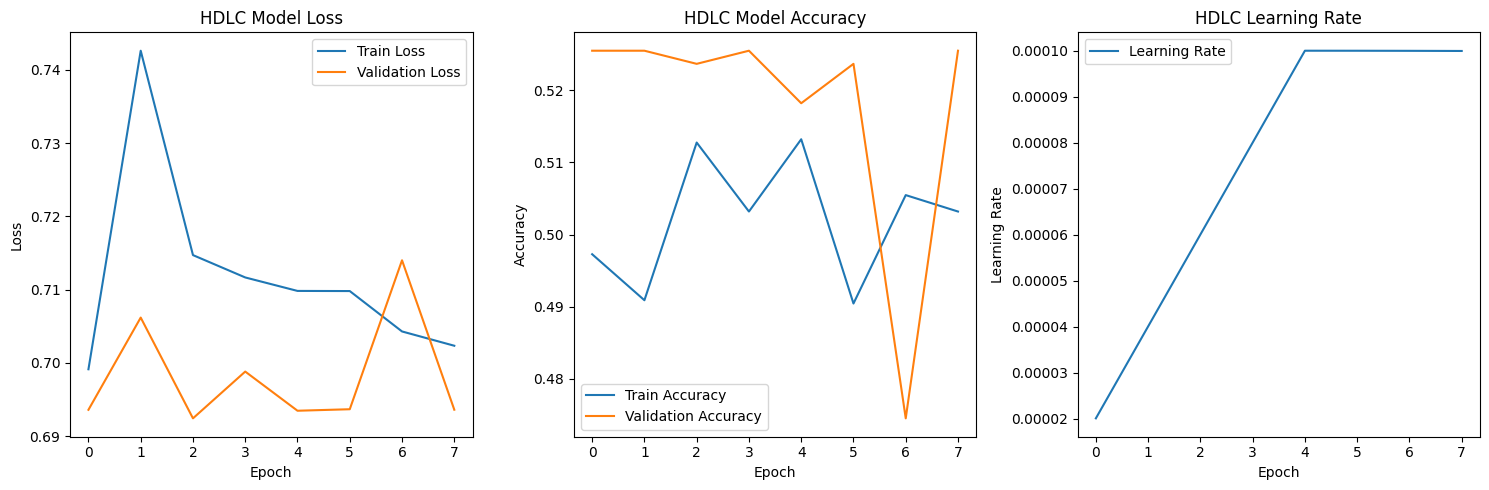

Training model for TG
Epoch 1/200
Train Loss: 0.6974, Train Accuracy: 0.5159
Val Loss: 0.6879, Val Accuracy: 0.5372
Epoch duration: 205.66 seconds
Current learning rate: 0.000020
Best model updated
----------------------------------------
Epoch 2/200
Train Loss: 0.7256, Train Accuracy: 0.5192
Val Loss: 0.7049, Val Accuracy: 0.4678
Epoch duration: 171.34 seconds
Current learning rate: 0.000040
Best model not updated
----------------------------------------
Epoch 3/200
Train Loss: 0.7115, Train Accuracy: 0.5242
Val Loss: 0.6963, Val Accuracy: 0.4645
Epoch duration: 171.24 seconds
Current learning rate: 0.000060
Best model not updated
----------------------------------------
Epoch 4/200
Train Loss: 0.7131, Train Accuracy: 0.5002
Val Loss: 0.7075, Val Accuracy: 0.4628
Epoch duration: 170.93 seconds
Current learning rate: 0.000080
Best model not updated
----------------------------------------
Epoch 5/200
Train Loss: 0.7084, Train Accuracy: 0.5027
Val Loss: 0.7063, Val Accuracy: 0.4628
Epoc

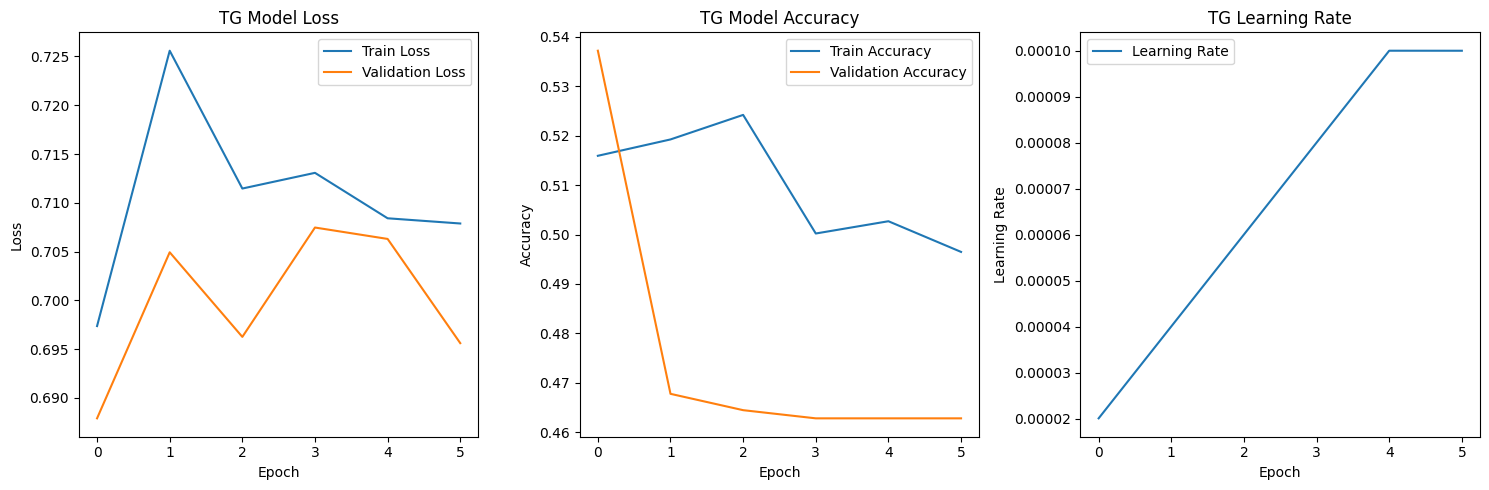

All models have been trained and saved.


In [ ]:
import os
import random
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from timm.scheduler import CosineLRScheduler
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import torch.backends.cudnn as cudnn
import timm

# Ensure deterministic behavior for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    cudnn.deterministic = True

# Training settings
num_epochs = 200
patience = 5
seed = 42
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"
save_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/"

seed_everything(seed)

# Dataset class definition
class FundusDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.loc[idx, 'filename'])
        image = Image.open(img_name).convert('RGB')
        label = self.data.loc[idx, 'class']
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations and augmentations
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

# Training function
def train(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).float()
        inputs = inputs.to(memory_format=torch.channels_last)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        all_preds.extend((torch.sigmoid(outputs) >= 0.5).float().cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = accuracy_score(all_targets, all_preds)
    return epoch_loss, epoch_accuracy

# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            inputs = inputs.to(memory_format=torch.channels_last)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            all_preds.extend((torch.sigmoid(outputs) >= 0.5).float().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = accuracy_score(all_targets, all_preds)
    return epoch_loss, epoch_accuracy

# Function to train and save model for each metric
def train_and_save_model(data, metric_name):
    print(f"Training model for {metric_name}")

    # Filter the dataset to include only 'high' and 'low' in the class
    filtered_df = data[data[f'{metric_name}_class'].isin(['high', 'low'])].reset_index(drop=True)

    # Map 'high' to 1 and 'low' to 0
    label_map = {'low': 0, 'high': 1}
    filtered_df['class'] = filtered_df[f'{metric_name}_class'].map(label_map)

    # Create datasets and dataloaders
    full_dataset = FundusDataset(filtered_df, img_dir)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed)
    )

    train_dataset.dataset.transform = transform_train
    val_dataset.dataset.transform = transform_val

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

    # Load model
    model = timm.create_model('swin_base_patch4_window12_384', num_classes=1, pretrained=False)

    # Use GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    # CosineLRScheduler settings
    scheduler = CosineLRScheduler(
        optimizer,
        t_initial=num_epochs,
        lr_min=1e-7,
        warmup_t=5,
        warmup_lr_init=1e-7,
        warmup_prefix=True,
    )

    scaler = torch.amp.GradScaler()  # Updated GradScaler usage

    # Training loop
    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        scheduler.step(epoch + 1)

        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        is_best = early_stopping(val_loss, model)
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        print(f"Epoch duration: {epoch_duration:.2f} seconds")
        print(f"Current learning rate: {current_lr:.6f}")
        print(f"Best model {'updated' if is_best else 'not updated'}")
        print("-" * 40)

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Save the model
    save_path = os.path.join(save_dir, f"{metric_name}.pth")
    torch.save(early_stopping.best_model, save_path)
    print(f"Model for {metric_name} saved to {save_path}")

    # Plot training history
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{metric_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{metric_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['lr'], label='Learning Rate')
    plt.title(f'{metric_name} Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    metrics = ['AC', 'SBP', 'DBP', 'HDLC', 'TG']

    for metric in metrics:
        train_and_save_model(data, metric)

print("All models have been trained and saved.")

### inference results

In [ ]:
import os
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms
import timm
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm  # tqdm のインポート

# モデルファイルと画像ディレクトリのパス
model_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"

# 推論結果を保存するファイルパス
inference_csv_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/inference.csv"

# 推論対象となる項目
metrics = ["age", "AC", "SBP", "DBP", "HDLC", "TG"]

# モデルの読み込みとデバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データフレームの初期化
inference_df = pd.DataFrame(columns=["filename", "age", "AC", "SBP", "DBP", "HDLC", "TG"])

# 画像ファイルの読み込みと推論
for filename in tqdm(os.listdir(img_dir), desc="推論中"):  # tqdm を使って進捗を表示
    if filename.endswith(".jpg"):
        # 画像ファイルのパス
        img_path = os.path.join(img_dir, filename)

        # 画像の読み込みと前処理
        image = Image.open(img_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        input_tensor = transform(image).unsqueeze(0).to(device)

        # 各項目の推論結果を格納
        predictions = {}
        for metric in metrics:
            # モデルの読み込み
            model_path = os.path.join(model_dir, f"{metric}.pth")
            model = timm.create_model('swin_base_patch4_window12_384', num_classes=1, pretrained=False)
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
            model = model.to(device)

            # 推論の実行
            with torch.no_grad():
                output = model(input_tensor.to(memory_format=torch.channels_last)).squeeze()

            # 結果を格納
            if metric == "age":
                predictions[metric] = output.item()
            else:
                predictions[metric] = torch.sigmoid(output).item()

        # データフレームに推論結果を追加 (pandas.concat() を使用)
        new_row = pd.DataFrame({"filename": [filename], **predictions})
        inference_df = pd.concat([inference_df, new_row], ignore_index=True)

# データフレームをCSVファイルに保存
inference_df.to_csv(inference_csv_path, index=False)
print(f"推論結果が {inference_csv_path} に保存されました。")

In [10]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm

# Define constants
IMG_DIR = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"
MODEL_DIR = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model"
OUTPUT_FILE = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/inference.csv"

# Dataset class definition
class FundusDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
dataset = FundusDataset(IMG_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# Function to load model
def load_model(model_path):
    model = timm.create_model('swin_base_patch4_window12_384', num_classes=1, pretrained=False)
    model.load_state_dict(torch.load(model_path))
    return model

# Inference function
def inference(model, dataloader, device):
    model.eval()
    predictions = []
    filenames = []

    with torch.no_grad():
        for inputs, batch_filenames in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            predictions.extend(outputs.cpu().numpy())
            filenames.extend(batch_filenames)

    return predictions, filenames

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Initialize results dictionary
    results = {'filename': []}

    # List of models and their corresponding column names
    models = {
        'age.pth': 'age_prediction',
        'AC.pth': 'AC_prediction',
        'SBP.pth': 'SBP_prediction',
        'DBP.pth': 'DBP_prediction',
        'HDLC.pth': 'HDLC_prediction',
        'TG.pth': 'TG_prediction'
    }

    # Perform inference for each model
    for model_file, column_name in models.items():
        print(f"Performing inference for {model_file}")
        model_path = os.path.join(MODEL_DIR, model_file)
        model = load_model(model_path).to(device)

        predictions, filenames = inference(model, dataloader, device)

        if 'filename' not in results:
            results['filename'] = filenames

        if model_file == 'age.pth':
            # For age, we don't need to apply sigmoid
            results[column_name] = predictions
        else:
            # For binary classification models, apply sigmoid and round
            results[column_name] = [1 if pred >= 0.5 else 0 for pred in torch.sigmoid(torch.tensor(predictions))]

    # Create DataFrame and save to CSV
    df_results = pd.DataFrame(results)
    df_results.to_csv(OUTPUT_FILE, index=False)
    print(f"Results saved to {OUTPUT_FILE}")

Performing inference for age.pth


<ipython-input-10-5298cf64226e>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Performing inference for AC.pth
Performing inference for SBP.pth
Performing inference for DBP.pth
Performing inference for HDLC.pth
Performing inference for TG.pth
Results saved to /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/inference.csv


In [18]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm

# Define constants
IMG_DIR = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"
MODEL_DIR = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model"
OUTPUT_FILE = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/inference.csv"

# Dataset class definition with more detailed error handling and logging
class FundusDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        if not os.path.exists(img_dir):
            raise FileNotFoundError(f"Directory not found: {img_dir}")
        self.image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Found {len(self.image_files)} images in {img_dir}")
        if len(self.image_files) == 0:
            print("Warning: No image files found. Accepted formats: .png, .jpg, .jpeg")
            print("Contents of the directory:")
            print(os.listdir(img_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.image_files[idx])
        try:
            with Image.open(img_name) as img:
                image = img.convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.image_files[idx]
        except Exception as e:
            print(f"Error loading image {img_name}: {str(e)}")
            return None, self.image_files[idx]

# Inference function
def inference(model, dataloader, device):
    model.eval()
    predictions = []
    filenames = []

    with torch.no_grad():
        for inputs, batch_filenames in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            predictions.extend(outputs.cpu().numpy())
            filenames.extend(batch_filenames)

    return predictions, filenames

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
try:
    dataset = FundusDataset(IMG_DIR, transform=transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
    print(f"DataLoader created with {len(dataloader)} batches")
except Exception as e:
    print(f"Error creating dataset or dataloader: {str(e)}")
    raise

# Function to check image loading
def check_image_loading(dataloader):
    print("Checking image loading...")
    for i, (images, filenames) in enumerate(dataloader):
        if images is None:
            print(f"Batch {i}: Images are None")
        else:
            print(f"Batch {i}: Successfully loaded {len(filenames)} images")
            print(f"Image tensor shape: {images.shape}")
            print(f"Sample filenames: {filenames[:5]}")
        if i == 0:  # Only check the first batch for brevity
            break
    print("Image loading check complete")

# Main execution
if __name__ == "__main__":
    print(f"Image directory: {IMG_DIR}")
    print(f"Directory exists: {os.path.exists(IMG_DIR)}")
    print(f"Directory contents: {os.listdir(IMG_DIR)[:10]}...")  # Show first 10 items

    check_image_loading(dataloader)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize results dictionary
    results = {'filename': []}

    # List of models and their corresponding column names
    models = {
        'age.pth': 'age_prediction',
        'AC.pth': 'AC_prediction',
        'SBP.pth': 'SBP_prediction',
        'DBP.pth': 'DBP_prediction',
        'HDLC.pth': 'HDLC_prediction',
        'TG.pth': 'TG_prediction'
    }

    # Perform inference for each model
    for model_file, column_name in models.items():
        print(f"Performing inference for {model_file}")
        model_path = os.path.join(MODEL_DIR, model_file)
        model = load_model(model_path)
        if model is None:
            print(f"Skipping inference for {model_file} due to loading error")
            continue
        model = model.to(device)

        predictions, filenames = inference(model, dataloader, device)

        if len(predictions) == 0:
            print(f"No predictions were made for {model_file}")
            continue

        if 'filename' not in results or len(results['filename']) == 0:
            results['filename'] = filenames

        if model_file == 'age.pth':
            # For age, we don't need to apply sigmoid
            results[column_name] = predictions
        else:
            # For binary classification models, apply sigmoid and round
            #results[column_name] = [1 if pred >= 0.5 else 0 for pred in torch.sigmoid(torch.tensor(predictions))]
            results[column_name] = torch.sigmoid(torch.tensor(predictions)).tolist()


        print(f"Added {len(predictions)} predictions for {column_name}")

    # Create DataFrame and save to CSV
    df_results = pd.DataFrame(results)
    print(f"DataFrame shape: {df_results.shape}")
    print(f"DataFrame columns: {df_results.columns}")
    print(df_results.head())

    df_results.to_csv(OUTPUT_FILE, index=False)
    print(f"Results saved to {OUTPUT_FILE}")

    # Additional check
    if os.path.exists(OUTPUT_FILE):
        saved_df = pd.read_csv(OUTPUT_FILE)
        print(f"Saved CSV file shape: {saved_df.shape}")
        print(f"Saved CSV file columns: {saved_df.columns}")
        print(saved_df.head())
    else:
        print(f"Error: {OUTPUT_FILE} was not created")

Found 5000 images in /content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px
DataLoader created with 625 batches
Image directory: /content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px
Directory exists: True
Directory contents: ['img79763903_00_1R.jpg', 'img79667108_00_1R.jpg', 'img79647704_00_1R.jpg', 'img79780481_00_1R.jpg', 'img79716254_00_1R.jpg', 'img79748133_00_1R.jpg', 'img79680695_00_1R.jpg', 'img79692970_00_1R.jpg', 'img79637901_00_1R.jpg', 'img79703652_00_1R.jpg']...
Checking image loading...
Batch 0: Successfully loaded 8 images
Image tensor shape: torch.Size([8, 3, 384, 384])
Sample filenames: ['img79763903_00_1R.jpg', 'img79667108_00_1R.jpg', 'img79647704_00_1R.jpg', 'img79780481_00_1R.jpg', 'img79716254_00_1R.jpg']
Image loading check complete
Using device: cuda:0
Performing inference for age.pth


<ipython-input-11-c08a9d6dbf8d>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Successfully loaded model from /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/age.pth
Added 5000 predictions for age_prediction
Performing inference for AC.pth
Successfully loaded model from /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/AC.pth
Added 5000 predictions for AC_prediction
Performing inference for SBP.pth
Successfully loaded model from /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/SBP.pth
Added 5000 predictions for SBP_prediction
Performing inference for DBP.pth
Successfully loaded model from /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/DBP.pth
Added 5000 predictions for DBP_prediction
Performing inference for HDLC.pth
Successfully loaded model from /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/HDLC.pth
Added 5000 predictions for HDLC_prediction
Performing inference for TG.pth
Successfully loaded model from /content/drive/

In [26]:
# Code to open the CSV file from the specified path in Google Drive
import pandas as pd

# Path specified by the user
file_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/merged_data.csv"

merged_data = pd.read_csv(file_path)
# Display the first few rows to confirm
merged_data.head()



,filename,age_prediction,AC_prediction,SBP_prediction,DBP_prediction,HDLC_prediction,TG_prediction,age,AC,SBP,DBP,HDLC,TG,BS,METS
0,img79763903_00_1R.jpg,47.236675,0.526638,0.477014,0.542116,0.536475,0.459794,44,78.6,113,71,58,63,81,0
1,img79667108_00_1R.jpg,48.155956,0.530819,0.476934,0.547806,0.536333,0.459517,52,84.8,128,83,55,201,69,0
2,img79647704_00_1R.jpg,42.992264,0.464070,0.471797,0.473804,0.537714,0.437007,41,88.8,131,83,76,56,96,0
3,img79780481_00_1R.jpg,50.210370,0.533914,0.474907,0.620379,0.536021,0.464644,50,92.1,155,97,39,316,84,1
4,img79716254_00_1R.jpg,48.818058,0.515803,0.479442,0.564467,0.536731,0.457607,46,84.3,128,91,63,198,88,0


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# データの準備
X = merged_data[['age_prediction', 'AC_prediction', 'SBP_prediction',
                 'DBP_prediction', 'HDLC_prediction', 'TG_prediction']]
y = merged_data['METS']

# データを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. ロジスティック回帰
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
report_log_reg = classification_report(y_test, y_pred_log_reg)

# 2. ランダムフォレスト分類
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf)

In [28]:
report_log_reg

'              precision    recall  f1-score   support\n\n           0       0.57      0.51      0.54       501\n           1       0.56      0.62      0.59       499\n\n    accuracy                           0.57      1000\n   macro avg       0.57      0.57      0.56      1000\nweighted avg       0.57      0.57      0.56      1000\n'

In [29]:
report_rf

'              precision    recall  f1-score   support\n\n           0       0.57      0.54      0.56       501\n           1       0.56      0.58      0.57       499\n\n    accuracy                           0.56      1000\n   macro avg       0.56      0.56      0.56      1000\nweighted avg       0.56      0.56      0.56      1000\n'